# Molecular Dynamics : Introduction

In this exercise, we discuss a simple implementation of an N-body gravity simulation.

In [1]:
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import enum
from copy import deepcopy
import time
from abc import ABCMeta

We will use two classes ***Simulation*** and ***Particle*** for implementing a simple example. If you are not familiar with classes in Python, please look at a [tutorial](https://docs.python.org/3/tutorial/classes.html).

## Task 1: The Simulator

In this task we take a look at a simple particle simulation program.

### Particle
Have a look at the following class which describes a particle:

In [2]:
class Particle(metaclass=ABCMeta):

    def __init__(self, id, dim=2, lower=0, upper=1):
        self.id = id
        self.mass = 1.0
        self.coordinates = np.random.uniform(lower, upper, dim)
        self.velocity = np.random.uniform(-1, 1, dim)
        self.force = np.zeros(dim)

### Force

Complete the implementation of the function `gravity()` in the next cell. It should calculate the gravitation `p_j` induces on `p_i`.

The formula for the calculation of the gravitational force is:

$$F = \frac{G \cdot m_1 m_2}{||x_1 - x_2||^3}(x_1 - x_2)$$

with:

  | Name  | Explanation      |
  |:-----:|:----------------:|
  | $G$   | gravity constant |
  | $m_i$ | mass of particle i |
  | $x_i$ | position of particle i (in form vector) |


In [6]:
# %load solution_gravity.py
def gravity(p_i, p_j, constant = 1.):
    """
    Calculates the gravity p_j applies to p_i
    Args:
        p_i: Particle i
        p_j: Particle j
        constant: Gravity constant

    Returns:
        Force applied by p_j on p_i
    """
    direction = p_i.coordinates - p_j.coordinates

    dist_squared = np.dot(direction, direction)
    dist = math.sqrt(dist_squared)

    factor = (constant * p_i.mass * p_j.mass) / (dist * dist * dist)

    return factor * direction


### Simulation

This class defines the whole simulation workflow including a visualization.

In [7]:
class Simulation(metaclass=ABCMeta):

    def __init__(self, num_particles=20, delta_t=0.01):
        self.dim = 2
        self.particles = []
        for index in range(num_particles):
            self.particles.append(Particle(index, dim=self.dim))
        self.delta_t = delta_t
        self.boxMin = [0., 0.]
        self.boxMax = [1., 1.]
        self.time_simulation = 0.
        self.time_force = 0.
        self.time_positions = 0.
        self.time_velocities = 0.

    def update_positions(self):
        """
        Update all particle positions according to the current velocities.
        Also applies wall boundary conditions.
        """
        delta_t_squared_half = 0.5 * self.delta_t * self.delta_t
        for p in self.particles:
            # move particle to new position
            p.coordinates += (self.delta_t * p.velocity) + (delta_t_squared_half * p.force)
            # respect boundaries
            for i in range(len(p.coordinates)):
                # if we are near a boundary invert the direction of the velocity
                if (p.coordinates[i] - self.boxMin[i]) < 1e-2 or (self.boxMax[i] - p.coordinates[i]) < 1e-2:
                    p.velocity[i] *= -1.0
                # if we crossed the boundary reset the particle to the border
                if p.coordinates[i] < self.boxMin[i]:
                    p.coordinates[i] = self.boxMin[i]
                if p.coordinates[i] > self.boxMax[i]:
                    p.coordinates[i] = self.boxMax[i]

    def update_velocities(self):
        """
        Half a velocity update for all particles.
        """
        delta_t_half = 0.5 * self.delta_t
        for p in self.particles:
            p.velocity +=  delta_t_half * p.force / p.mass

    def calculate_forces(self):
        """
        Calculate all pairwise gravity forces.
        """
        for p_i in self.particles:
            # reset forces
            p_i.force = np.zeros(self.dim)
            # direct sum
            for p_j in self.particles:
                # skip self interaction
                if p_i.id == p_j.id:
                    continue
                p_i.force += gravity(p_i, p_j)

    def get_coordinates(self):
        """Return the seprate arrays containing the x and y coordinates of particles
        """
        x = np.zeros(len(self.particles))
        y = np.zeros(len(self.particles))
        for idx, particle in enumerate(self.particles):
            x[idx], y[idx] = particle.coordinates[0], particle.coordinates[1]
        return  x, y
    
    def init_simulation(self, ax):
        ax.set_xlim((self.boxMin[0], self.boxMax[0]))
        ax.set_ylim((self.boxMin[1], self.boxMax[1]))

        self.particles_plot, = ax.plot([], [], 'go')
        self.particles_plot.set_data([], [])

    def do_simulation(self):
        """
        Performs one time step of the simulation.
        """
        time_iteration_start = time.time()

        # update positions and periodic boundaries
        time_positions_start = time.time()
        self.update_positions()
        self.time_positions += time.time() - time_positions_start

        # update velocities part 1
        time_velocities_start = time.time()
        self.update_velocities()
        self.time_velocities += time.time() - time_velocities_start

        # reset and calculate forces
        time_force_start = time.time()
        self.calculate_forces()
        self.time_force += time.time() - time_force_start

        # update velocities part 2
        time_velocities_start = time.time()
        self.update_velocities()
        self.time_velocities += time.time() - time_velocities_start

        self.time_simulation += time.time() - time_iteration_start

    def get_animation_frame(self, i):
        self.do_simulation()

        x, y = self.get_coordinates()
        self.particles_plot.set_data(x, y)
        plt.title('t=' + str(i + 1))
        return (self.particles_plot,)
    
    def get_time_analysis(self):
        """
        Prints the percentage of time stpent on different parts of the simulation
        """
        print("Total time:  {:.2f} [s]".format(self.time_simulation))
        print("Percentages of time:")
        print("   Positions          {:.2f}%".format(self.time_positions / self.time_simulation * 100.))
        print("   Velocities         {:.2f}%".format(self.time_velocities / self.time_simulation * 100.))
        print("   Force Calculation {:.2f}%".format(self.time_force / self.time_simulation * 100.))

## Task 2: Two-Body Simulation

Let us simulate a simple two body interaction. We simulate the head on collision of two particles of same mass in a box.

Modify the value of delta_t, say increase it to 0.05. What do you observe? Is the behavior physical? Can you explain the behavior?

RuntimeError: Requested MovieWriter (ffmpeg) not available

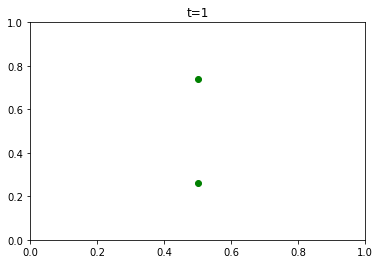

In [8]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
num_time_steps = 100

# Create a simulation object
simulation = Simulation(delta_t=.01, num_particles=2)

# the object initialises the coordinates and velocities with random values
# for head on collision we modify the values
simulation.particles[0].coordinates = np.array([0.5, .25])
simulation.particles[1].coordinates = np.array([0.5, .75])
simulation.particles[0].velocity = np.array([0., 1.])
simulation.particles[1].velocity = np.array([0., -1.])

# Do simulation and get animation
simulation.init_simulation(ax)
anim = animation.FuncAnimation(fig, simulation.get_animation_frame, frames=num_time_steps, interval=300, blit=True)

# Get the animation
HTML(anim.to_html5_video())

## Task 3: N-Body Simulation

Now let us increase the number of particles to 100.

The particle positions are generated randomly so if you run into problems either change something that affects the seed or decrease your `delta_t`.

RuntimeError: Requested MovieWriter (ffmpeg) not available

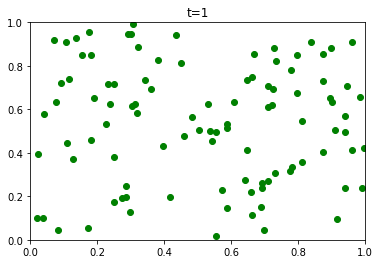

In [9]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
num_time_steps = 100

# Create a simulation object
simulation = Simulation(delta_t=.0005, num_particles=100)

# Do simulation
simulation.init_simulation(ax)
anim = animation.FuncAnimation(fig, simulation.get_animation_frame, frames=num_time_steps, interval=300, blit=True)

# Get the animation
HTML(anim.to_html5_video())

### Breakdown of the Simulation Time

Check which part of the simulation consumes most of the time.

In [ ]:
simulation.get_time_analysis()

### Observations
From the above two examples we can make following observations:
1. Time stepping methods controls the stability of the problem. Improper handling of time stepping can lead to non-physical solutions
2. Force Calculation takes up most of the time of the simulation. In order to make the simulation faster, we need to increase algorithmic efficiency there.